In [1]:
""" 
Prepare MIMIC dataset to run deep patient on the dataset
Desired columns: Patient ID, gender, list of ICD codes, mortality
TODO: add more columns: e.g. number of days in ICU
"""
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys


In [2]:
"""
Read in ADMISSIONS.csv and construct patient ID to admission ID map
"""

pid_admids = {}

admission_file = open("../mimiciii/ADMISSIONS.csv", 'r')
admission_file.readline()
for line in admission_file:
    tokens = line.strip().split(',')
    pid = int(tokens[1])
    admId = int(tokens[2])
    if pid in pid_admids: pid_admids[pid].append(admId)
    else: pid_admids[pid] = [admId]
admission_file.close()


In [3]:
""" 
Read in PATIENTS.csv and construct (1) patient ID to gender map, and (2) patient ID to expire map
"""
pid_gender = {}
pid_expire = {}
patient_file = open("../mimiciii/PATIENTS.csv", 'r')
patient_file.readline()
for line in patient_file:
    tokens = line.strip().split(',')
    pid = int(tokens[1])
    gender = str(tokens[2])
    pid_gender[pid] = gender[1] # remove quotes
    expire = int(tokens[-1])
    pid_expire[pid] = expire

In [4]:
""" 
Consruct admission ID to ICD codes mapping
"""

def convert_to_icd9(dxStr):
        """ 
        Adapted from https://github.com/mp2893/med2vec/blob/master/process_mimic.py
        """
	if dxStr.startswith('E'):
		if len(dxStr) > 4: return dxStr[:4] + '.' + dxStr[4:]
		else: return dxStr
	else:
		if len(dxStr) > 3: return dxStr[:3] + '.' + dxStr[3:]
		else: return dxStr

admid_codes = {}
diagnose_file = open("../mimiciii/DIAGNOSES_ICD.csv", 'r')
diagnose_file.readline()
for line in diagnose_file: # read ADMISSIONS.CSV in order
    tokens = line.strip().split(',')
    admid = int(tokens[2])
    dxStr = 'D_' + convert_to_icd9(tokens[4][1:-1])

    if admid in admid_codes: 
        admid_codes[admid].append(dxStr)
    else: 
        admid_codes[admid] = [dxStr]

diagnose_file.close()
# print(admid_codes)


In [5]:
""" 
Construct patient ID to ICD codes mapping
"""

pid_codes = {}

for pid, admids in pid_admids.items():
    if pid not in pid_codes:
        pid_codes[pid] = []
    for admid in admids:
        pid_codes[pid].extend(admid_codes[admid])
# print(pid_codes)

In [6]:
"""
Convert str codes to int codes
We use 0 to denote NA code in later analysis
"""

types = {}
for pid, codes in pid_codes.items():
    new_codes = []
    for code in codes:
        if code not in types:
            types[code] = len(types) + 1
        new_codes.append(types[code])
    pid_codes[pid] = new_codes


In [7]:
""" 
Construct a dataframe to store all information including
- patient ID (index key)
- gender
- expire (mortality)
- list of ICD codes
"""

patient_agg_df = pd.DataFrame(columns=['pid','gender','expire','ICD codes'])

min_num_codes = float("inf")
max_num_codes = 0

for pid, codes in pid_codes.items():
    new_row = {"pid": pid, "gender": pid_gender[pid], "expire": pid_expire[pid], "ICD codes": pid_codes[pid]}
    min_num_codes = min(min_num_codes, len(pid_codes[pid]))
    max_num_codes = max(max_num_codes, len(pid_codes[pid]))
    patient_agg_df = pd.concat([patient_agg_df, pd.DataFrame([new_row])], ignore_index=True)
    
patient_agg_df.to_csv("../mimiciii/PATIENTS_AGG.csv", index=None, header=True)

In [8]:
print("min_num_codes is:", min_num_codes)
print("max_num_codes is:", max_num_codes)
print("number of ICD code is:", len(types))

min_num_codes is: 1
max_num_codes is: 540
number of ICD code is: 6985


In [9]:
""" 
Select the top 50 codes, and save to PATIENT_AGG_50.csv
"""

' \nSelect the top 50 codes, and save to PATIENT_AGG_50.csv\n'

In [10]:
""" 
Calculate the frequency of ICD codes
"""

import collections

all_patient_codes = []

for pid, codes in pid_codes.items():
    all_patient_codes.extend(pid_codes[pid])

all_codes_counter = collections.Counter(all_patient_codes)

In [12]:
""" 
Find the top 50 ICD codes
"""

all_codes_dict = collections.OrderedDict(all_codes_counter)
all_codes_dict  = sorted(all_codes_dict.items(), key=lambda i: i[1], reverse=True)
top50_codes_dict = all_codes_dict[:50]
top50_codes = [item[0] for item in top50_codes_dict]
print(len(top50_codes))
print(top50_codes)

50
[7, 29, 30, 8, 88, 24, 12, 118, 124, 23, 18, 36, 35, 112, 65, 47, 85, 164, 37, 87, 64, 55, 103, 33, 183, 193, 248, 71, 31, 68, 19, 25, 268, 378, 21, 262, 149, 11, 163, 127, 10, 121, 62, 373, 59, 583, 141, 95, 57, 451]


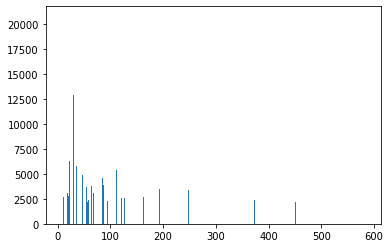

In [12]:
""" 
Select only top 50 codes from all_patient_codes, and plot distribution
"""

top50_patient_codes = list(filter(lambda x: x in top50_codes, all_patient_codes)) 
top50_patient_codes_counter = collections.Counter(top50_patient_codes)
plt.bar(top50_patient_codes_counter.keys(), top50_patient_codes_counter.values())
plt.show()
print(top50_patient_codes_counter = collections.Counter(top50_patient_codes))


In [14]:
""" 
Construct dataframe containing only the top 50 codes
"""

patient_50_agg_df = pd.DataFrame(columns=['pid','gender','expire','ICD codes'])

min_num_codes = float("inf")
max_num_codes = 0

for pid, codes in pid_codes.items():
    filtered_pid_codes = list(filter(lambda x: (x in top50_codes),  pid_codes[pid])) 
    new_row = {"pid": pid, "gender": pid_gender[pid], "expire": pid_expire[pid], "ICD codes": filtered_pid_codes}
    min_num_codes = min(min_num_codes, len(pid_codes[pid]))
    max_num_codes = max(max_num_codes, len(pid_codes[pid]))
    patient_50_agg_df = pd.concat([patient_50_agg_df, pd.DataFrame([new_row])], ignore_index=True)
    

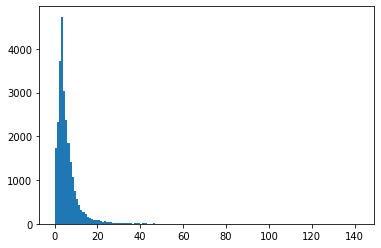

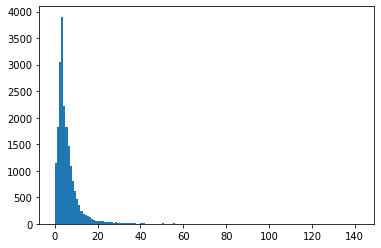

In [17]:
""" 
Plot number of codes histogram for males and females
"""

def code_len(df):
    """ 
    Get ICD code length in dataframe (df)
    """
    code_lens = []
    for _, row in df.iterrows():
        code_lens.append(len(row['ICD codes']))
    return code_lens

male_50_agg_df = patient_50_agg_df[patient_50_agg_df['gender'] == 'M']
female_50_agg_df = patient_50_agg_df[patient_50_agg_df['gender'] == 'F']

male_50_lens = code_len(male_50_agg_df)
female_50_lens = code_len(female_50_agg_df)

bin_width = 1
plt.hist(male_50_lens, bins = np.arange(min(male_50_lens), max(male_50_lens)+bin_width, bin_width))
plt.show()
plt.hist(female_50_lens, bins = np.arange(min(male_50_lens), max(male_50_lens)+bin_width, bin_width))
plt.show()



In [21]:
""" 
Filter out patients with less than 5 ICD codes
"""

patient_50_agg_df = patient_50_agg_df[patient_50_agg_df['ICD codes'].map(len) >= 5]
patient_50_agg_df.to_csv("../mimiciii/PATIENTS_50_AGG.csv", index=None, header=True)
